<a href="https://colab.research.google.com/github/basmala-kamal/tut-pricing-model/blob/main/faceserumstut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install requests beautifulsoup4


In [ ]:
import requests
from bs4 import BeautifulSoup


In [91]:
import json
import pandas as pd
import re

# 1. Load the JSON file
with open("face+serums.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to a pandas DataFrame for easier data manipulation
df = pd.DataFrame(data)
df = df.dropna(subset=["price"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""


def clean_price(price_str):
    if price_str is None:
        return None
    numeric_str = re.sub(r"[^\d\.]", "", price_str)
    try:
        return float(numeric_str)
    except ValueError:
        return None

df["price_numeric"] = df["price"].apply(clean_price)


def clean_rating(rating_str):
    if rating_str is None:
        return None


    match = re.search(r"\d+(\.\d+)?", rating_str)
    if match:
        try:
            return float(match.group(0))
        except ValueError:
            return None
    return None


df["rating_numeric"] = df["rating"].apply(clean_rating)


def extract_volume(title_str):
    # Check for "أوز" (prioritize this if found)
    match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:مل\.\s*أوز|أوز)', title_str)
    if match_oz:
        return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # Check for "مل" (only if "أوز" is not found)
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*مل', title_str)
    if match_ml:
        return float(match_ml.group(1))

    # Check for "أونص", "أونصة", or "اونصة" and convert to ml
    match_ounce = re.search(r'(\d+(?:\.\d+)?)\s*(?:أونص|اونص|أونصة|اونصة)', title_str)
    if match_ounce:
        return float(match_ounce.group(1)) * 29.5 # Convert oz to ml

    # If no match, return None
    return None


# Apply the function to the DataFrame
df["volume"] = df["title"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["title", "price_numeric"])

    # Drop duplicates based on 'name' and 'price_numeric'
    df = df.drop_duplicates(subset=["title", "price_numeric"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)
# ------------------------------------------------------------------------------
# Final cleaned DataFrame
df = df[~df["title"].str.contains("كريم", na=False)]
print(df)


                                                                                                                                                                                                        title  \
114                                                                                            VIP سيروم الذهب البيور من دكتور راشيل (الكل في واحد رفع وشد, تبييض, ترطيب, زيادة المرونة والاشراق)، كل الأنواع   
10                                                                                                                                                                أكسيس واي سيروم لتصحيح البقع الداكنة، 50 مل   
89                                                          أمبولة سيروم وجه بمستخلص سنتيلّا اسياتيكا 100% المدغشقري لتهدئة البشرة الحساسة وتلك المعرض لحب الشباب من سكِن 1004 سكين1004 للجنسين 100.0 ملليلتر   
35                 ادفانسيد كلينيكالز سيروم ببتيد للتجاعيد والخطوط الدقيقة والانتفاخات للوجه مرطب ومضاد مع الكولاجين يرفع ويوحد لون البشرة مصنوع من مستخلصات طبيعية 

In [92]:
df

,title,price,rating,link,price_numeric,rating_numeric,volume
114,"VIP سيروم الذهب البيور من دكتور راشيل (الكل في واحد رفع وشد, تبييض, ترطيب, زيادة المرونة والاشراق)، كل الأنواع",‏32.22 ريال,3.4 من 5 نجوم,https://www.amazon.sa/%D9%84%D9%84%D8%B4%D9%8A%D8%AE%D9%88%D8%AE%D8%A9-%D8%A8%D8%A7%D9%84%D9%83%D9%88%D9%84%D8%A7%D8%AC%D9%8A%D9%86%D8%8C-%D8%A7%D9%84%D9%87%D9%8A%D8%A7%D9%84%D9%88%D8%B1%D9%88%D9%86%D9%8A%D9%83%D8%8C-%D8%A7%D9%84%D9%86%D9%8A%D8%A7%D8%B3%D9%8A%D9%86%D8%A7%D9%85%D9%8A%D8%AF-%D8%B3%D9%88%D8%AA%D9%8A/dp/B0CFT3RF51,32.22,3.4,NaN
10,أكسيس واي سيروم لتصحيح البقع الداكنة، 50 مل,‏32.06 ريال,4.1 من 5 نجوم,https://www.amazon.sa/%D9%88%D8%A7%D9%84%D9%86%D9%8A%D8%A7%D8%B3%D9%8A%D9%86%D8%A7%D9%85%D9%8A%D8%AF-%D8%A8%D9%8A%D9%88%D8%AA%D9%8A-%D8%A7%D9%88%D9%81-%D9%85%D9%84%D9%84%D9%8A%D9%84%D8%AA%D8%B1%D8%8C-%D8%AC%D9%88%D8%B3%D9%8A%D9%87%D9%88%D9%86/dp/B086VKZZZY,32.06,4.1,50.000
89,أمبولة سيروم وجه بمستخلص سنتيلّا اسياتيكا 100% المدغشقري لتهدئة البشرة الحساسة وتلك المعرض لحب الشباب من سكِن 1004 سكين1004 للجنسين 100.0 ملليلتر,‏58.00 ريال,4.6 من 5 نجوم,https://www.amazon.sa/%D8%A8%D9%8A%D8%B1%D9%81%D9%83%D8%AA%D9%86%D8%AC-%D9%8A%D9%88%D8%B3%D9%8A%D8%B1%D9%8A%D9%86-%D8%A7%D9%84%D8%A3%D9%86%D9%88%D8%A7%D8%B9%D8%A9%D8%8C-%D9%84%D9%84%D8%AC%D9%86%D8%B3%D9%8A%D9%86%D8%8C-%D9%85%D9%84%D9%84%D9%8A%D9%84%D8%AA%D8%B1/dp/B0BDGCZG7S,58.00,4.6,100.000
35,ادفانسيد كلينيكالز سيروم ببتيد للتجاعيد والخطوط الدقيقة والانتفاخات للوجه مرطب ومضاد مع الكولاجين يرفع ويوحد لون البشرة مصنوع من مستخلصات طبيعية في الولايات المتحدة الامريكية. كل الأنواع,‏41.68 ريال,4.3 من 5 نجوم,https://www.amazon.sa/%D9%88%D8%A7%D9%84%D9%86%D9%8A%D8%A7%D8%B3%D9%8A%D9%86%D8%A7%D9%85%D9%8A%D8%AF-%D8%A8%D9%8A%D9%88%D8%AA%D9%8A-%D8%A7%D9%88%D9%81-%D9%85%D9%84%D9%84%D9%8A%D9%84%D8%AA%D8%B1%D8%8C-%D8%AC%D9%88%D8%B3%D9%8A%D9%87%D9%88%D9%86/dp/B086VKZZZY,41.68,4.3,NaN
207,اسايا سيروم وجه ريتينول 0.2% | صديق للمبتدئين | مضاد للشيخوخة والتجاعيد | سيروم ليلي للبشرة المتوهجة | فيتامين C وحمض الهيالورونيك | يقلل الخطوط الدقيقة ويعزز الكولاجين | لجميع انواع البشرة | 30 مل,‏70.18 ريال,4.8 من 5 نجوم,https://www.amazon.sa/%D8%AF%D9%8A-%D8%A7%D9%8A%D9%84%D9%8A%D9%81%D9%86%D8%AB-%D9%84%D9%84%D8%B4%D9%8A%D8%AE%D9%88%D8%AE%D8%A9-%D9%84%D9%84%D8%A7%D9%83%D8%B3%D8%AF%D8%A9-%D8%A7%D9%84%D8%B1%D8%B7%D9%88%D8%A8%D8%A9/dp/B09TJ5Z49R,70.18,4.8,30.000
24,الحد الأدنى ألفا أربوتين 2 للتصبغ والبقع الداكنة وتسمّر الشمس - مصل للوجه حمض الهيالورونيك لإزالة العيوب وعلامات حب الشباب وتفاوت لون البشرة 30 ملليلتر للجنسين,‏40.20 ريال,4.1 من 5 نجوم,https://www.amazon.sa/%D9%88%D8%A7%D9%84%D9%86%D9%8A%D8%A7%D8%B3%D9%8A%D9%86%D8%A7%D9%85%D9%8A%D8%AF-%D8%A8%D9%8A%D9%88%D8%AA%D9%8A-%D8%A7%D9%88%D9%81-%D9%85%D9%84%D9%84%D9%8A%D9%84%D8%AA%D8%B1%D8%8C-%D8%AC%D9%88%D8%B3%D9%8A%D9%87%D9%88%D9%86/dp/B086VKZZZY,40.20,4.1,30.000
7,الحد الادنى سيروم الوجه 10 نياسيناميد لعلاج علامات حب الشباب والعيوب وموازنة الزيوت - الزنك مصل تنقية مضاد لحب للبشرة الدهنية والمعرضة 30 ملليلتر للجنسين,‏38.00 ريال,4.2 من 5 نجوم,https://www.amazon.sa/%D9%88%D8%A7%D9%84%D9%86%D9%8A%D8%A7%D8%B3%D9%8A%D9%86%D8%A7%D9%85%D9%8A%D8%AF-%D8%A8%D9%8A%D9%88%D8%AA%D9%8A-%D8%A7%D9%88%D9%81-%D9%85%D9%84%D9%84%D9%8A%D9%84%D8%AA%D8%B1%D8%8C-%D8%AC%D9%88%D8%B3%D9%8A%D9%87%D9%88%D9%86/dp/B086VKZZZY,38.00,4.2,30.000
52,الحد الادنى سيروم وجه بحمض الترانيكساميك بنسبة 3% لعلاج الكلف والتصبغ والحمامي وندبات حب الشباب للوجه مع حمض الهيالورونيك لازالة وفرط التصبغ الالتهابي او الحمامي PIH & PIE 30 مل للجنسين,‏45.95 ريال,4.1 من 5 نجوم,https://www.amazon.sa/%D8%A8%D9%8A%D8%B1%D9%81%D9%83%D8%AA%D9%86%D8%AC-%D9%8A%D9%88%D8%B3%D9%8A%D8%B1%D9%8A%D9%86-%D8%A7%D9%84%D8%A3%D9%86%D9%88%D8%A7%D8%B9%D8%A9%D8%8C-%D9%84%D9%84%D8%AC%D9%86%D8%B3%D9%8A%D9%86%D8%8C-%D9%85%D9%84%D9%84%D9%8A%D9%84%D8%AA%D8%B1/dp/B0BDGCZG7S,45.95,4.1,30.000
71,ايستلين سيروم للوجه بفيتامين ايه ريتينول مقاوم للشيخوخة 30 مل، كل الأنواع,‏25.00 ريال,None,https://www.amazon.sa/%D8%A8%D9%8A%D8%B1%D9%81%D9%83%D8%AA%D9%86%D8%AC-%D9%8A%D9%88%D8%B3%D9%8A%D8%B1%D9%8A%D9%86-%D8%A7%D9%84%D8%A3%D9%86%D9%88%D8%A7%D8%B9%D8

In [93]:

def adjust_price_for_sets(df):
    def update_price(row):
        title = row["title"]

        # Case 1: Contains 'مجموعة' and 'قطع'
        if "مجموعة" in title and "قطع" in title:
            match = re.search(r'(\d+)\s*قطع', title)
            if match:
                num_items = int(match.group(1))
                if num_items > 0 and pd.notna(row["price_numeric"]):
                    return row["price_numeric"] / num_items

        # Case 2: Contains 'قطعتين' or 'زجاجتين'
        if re.search(r'(عبوتان|قطعتين|زجاجتين)', title):
            if pd.notna(row["price_numeric"]):
                return row["price_numeric"] / 2
        match = re.search(r'(\d+)\s*قوارير', title)
        if match:
            num_items = int(match.group(1))
            if num_items > 0 and pd.notna(row["price_numeric"]):
                return row["price_numeric"] / num_items
        match = re.search(r'عدد\s*(\d+)', title)
        if match:
            num_items = int(match.group(1))
            if num_items > 0 and pd.notna(row["price_numeric"]):
                return row["price_numeric"] / num_items

        # If no adjustments, return the original price
        return row["price_numeric"]

    # Apply the function to the 'price_numeric' column
    df["price_numeric"] = df.apply(update_price, axis=1)
    return df

# Apply the function to your DataFrame
df = adjust_price_for_sets(df)

# Example: Verify with updated rows that match 'مجموعة', 'قطعتين', or 'زجاجتين'
print(df[df["title"].str.contains("مجموعة|قطعتين|زجاجتين")])


                                                                                                                                                                                             title  \
241                                  بلوم مجموعة تنظيف القماش - مجموعة العناية بالبشرة للبشرة المعرضة لحب الشباب تتضمن قناع تقشير أشعة الشمس ومصل البقع اللبنية وتلاشي الندبات للوجه (عدد 2)، زهري   
277                                                     زيت الكركم بحمض الكوجيك من نالاكال مزيل البقع الداكنة للوجه مصل مصحح والكركم مضاد للشيخوخة ترطيب لتفتيح الوجه وجه للعيوب قطعتين كل الأنواع   
211  سيروم فيتامين C والريتينول وحمض الهيالورونيك للوجه من يوث، مجموعة العناية بالبشرة لمكافحة الشيخوخة والتفتيح والترطيب والتجاعيد، 3 قطع، للجنسين، 1.0 fluid_ounces، كل الأنواع، 3.0 أونصة سائلة   
215                                                                فوفل سيروم حمض الهيالورونيك للوجه مجموعة بي جلو للمبتدئين 035 اونصة 4 قوارير للأنثى جاف دهنية مزيج حساس عادي 100 ملليلتر للنساء   
219       

In [94]:
df_cleaned = (
    df[["title", "price_numeric", "rating_numeric", "volume"]]
    .dropna(subset=["title", "price_numeric", "rating_numeric","volume"])
)

df_cleaned.shape


(152, 4)

<Axes: xlabel='volume', ylabel='price_numeric'>

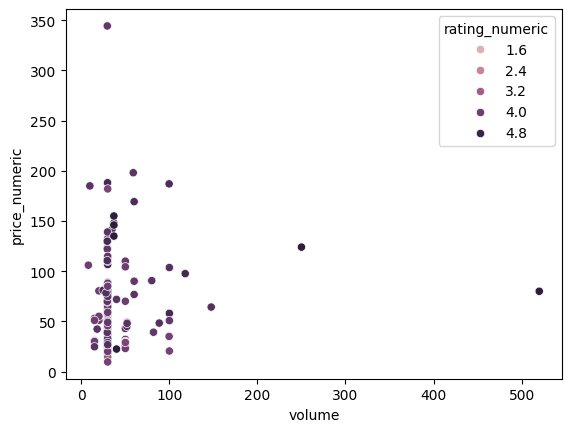

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data = df_cleaned, x = 'volume', y = 'price_numeric', hue = 'rating_numeric')

In [96]:
large = df_cleaned[df_cleaned["volume"] >=100]
large

,title,price_numeric,rating_numeric,volume
89,أمبولة سيروم وجه بمستخلص سنتيلّا اسياتيكا 100% المدغشقري لتهدئة البشرة الحساسة وتلك المعرض لحب الشباب من سكِن 1004 سكين1004 للجنسين 100.0 ملليلتر,58.0000,4.6,100.0
244,سيروم 1 من بودرة حمض الهيالورونيك النقي للوجه 10.000 جزء في المليون - مضاد للشيخوخة + الخطوط الدقيقة + ترطيب مكثف + مرطب + بشرة ممتلئة بشكل واضح + يمنع الام المثانة 4 اونصة سائلة,97.5900,4.6,118.0
66,سيروم بخاخ ايطالي وايت ترافل فيرست نباتي مرطب لامع للوجه - دالبا دالباميست بيدمونت للجنسين جاف عادي حساس مزيج دهنية 3.38 أونصة 100.0 مل من,103.6300,4.4,100.0
69,سيروم نياسيناميد بيور للوجه والجسم من اشلي شاين يرطب البشرة وتبييض 520 مل فيري سكين,80.0000,5.0,520.0
191,سيروم نياسيناميد بيور من اشلي شاين: لترطيب وتبييض الوجه والجسم لجميع انواع البشرة، 250 مل، كل الأنواع,124.0000,5.0,250.0
215,فوفل سيروم حمض الهيالورونيك للوجه مجموعة بي جلو للمبتدئين 035 اونصة 4 قوارير للأنثى جاف دهنية مزيج حساس عادي 100 ملليلتر للنساء,50.7525,4.2,100.0
136,مستحلب مرطب رايس سيراميد من ذا فيس شوب لطيف لتفتيح وحاجز واقي لوشن للوجه مغذي عميق للبشرة الناعمة والمرنة 5.0 اونصة سائلة لنوع حساسة للجنسين,64.2600,4.4,147.5
113,مصل الوجه التمهيدي للوجه دكتور راشيل عيار 24 قيراط 100 مل لكل انواع البشرة للجنسين كل الأنواع,20.4800,3.9,100.0


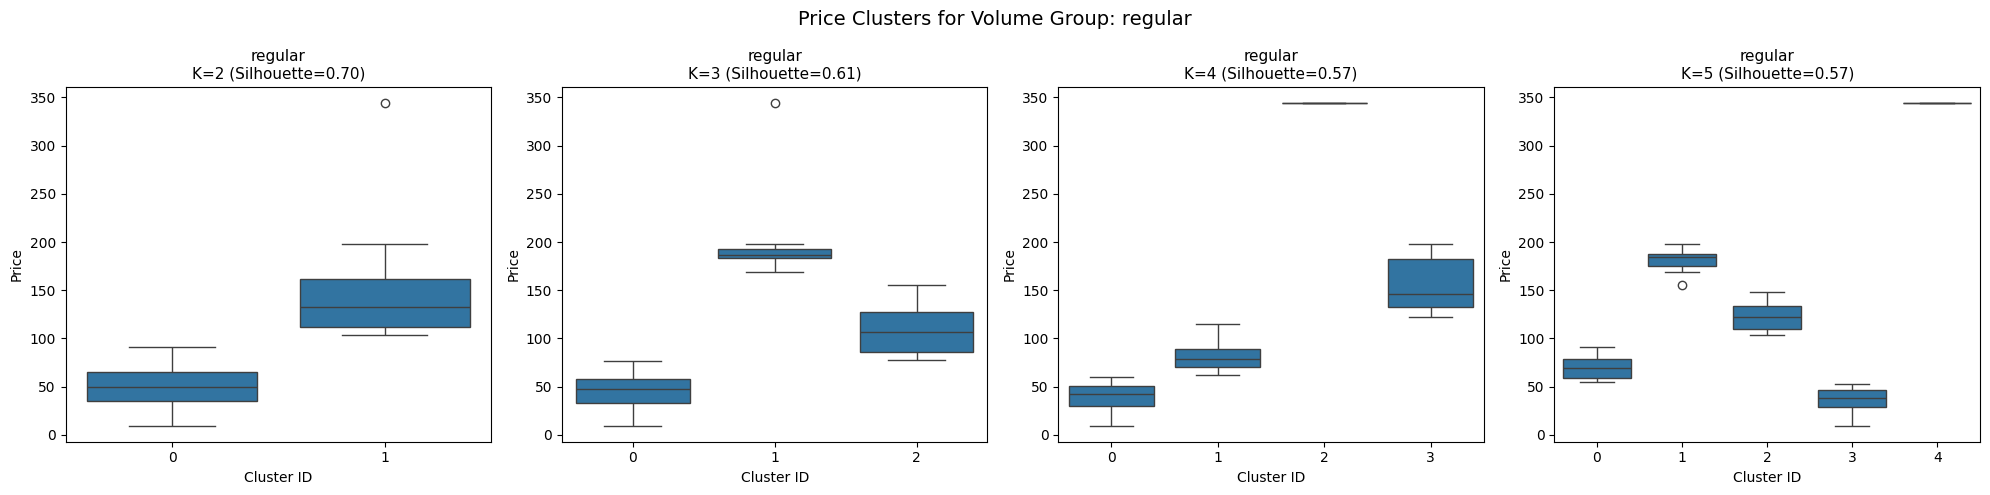

ValueError: Number of labels is 4. Valid values are 2 to n_samples - 1 (inclusive)

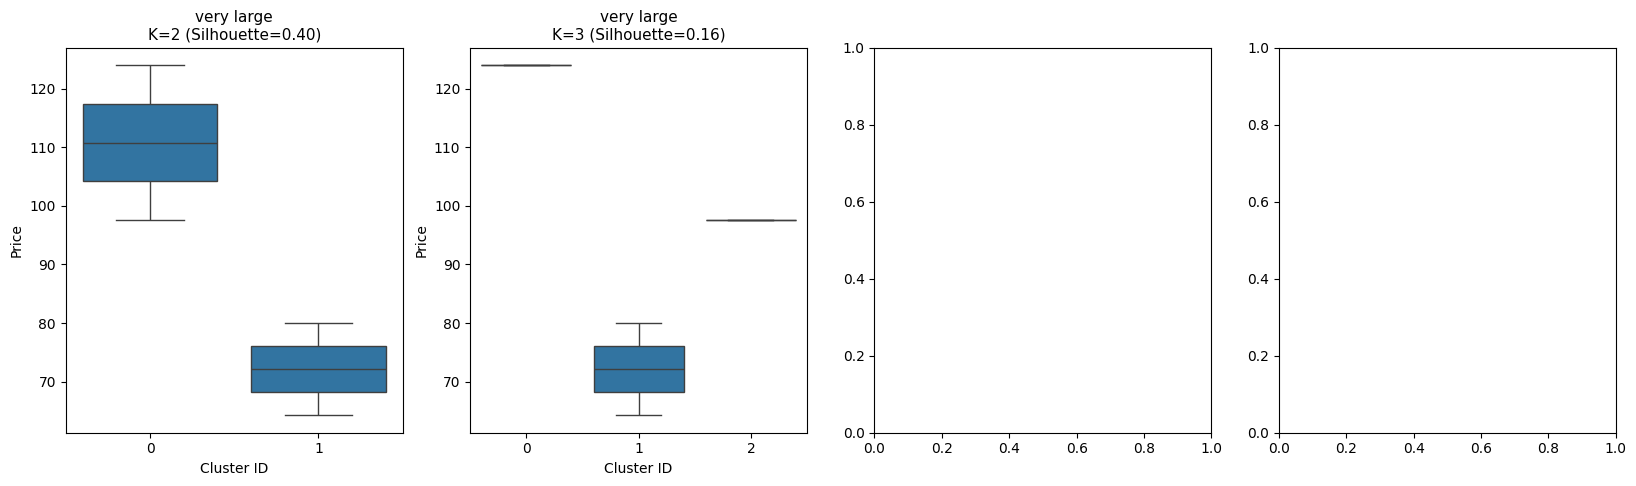

In [97]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure no NaNs in required columns
df_cleaned = df_cleaned.dropna(subset=["volume", "price_numeric"])

# 1) Create volume groups
df_cleaned["volume_group"] = pd.cut(
    df_cleaned["volume"],
    bins=[0, 100, 550],
    labels=["regular", "very large"],
    include_lowest=True  # Include 0 in the first group
)

for group_name in df_cleaned["volume_group"].unique():
    subset = df_cleaned[df_cleaned["volume_group"] == group_name].copy()

    if subset.empty:
        print(f"No data for group '{group_name}'. Skipping.")
        continue

    # 2) Scale ONLY price_numeric
    if len(subset) <= 1:
        print(f"Only one row in group '{group_name}'. Skipping clustering.")
        continue

    X_price = subset[["price_numeric"]].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_price)

    # Make a figure with 4 subplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

    for idx, k in enumerate([2,3,4,5]):
        if len(subset) < k:
            print(f"Skipping k={k} for group '{group_name}' due to insufficient data.")
            continue

        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        kmeans.fit(X_scaled)

        # Store cluster labels
        cluster_col = f"cluster_k{k}"
        subset[cluster_col] = kmeans.labels_

        # Silhouette score (handle cases with < 2 clusters)
        if len(subset[cluster_col].unique()) > 1:
            sil_score = silhouette_score(X_scaled, kmeans.labels_)
        else:
            sil_score = np.nan

        # 3) Visualize via boxplot
        sns.boxplot(
            x=cluster_col,
            y="price_numeric",
            data=subset,
            ax=axes[idx]
        )
        axes[idx].set_title(
            f"{group_name}\nK={k} (Silhouette={sil_score:.2f})",
            fontsize=11
        )
        axes[idx].set_xlabel("Cluster ID")
        axes[idx].set_ylabel("Price")

    # Save cluster labels back to df_cleaned
    for cluster_col in [f"cluster_k{k}" for k in [2,3,4,5]]:
        df_cleaned.loc[subset.index, cluster_col] = subset[cluster_col]

    plt.suptitle(f"Price Clusters for Volume Group: {group_name}", fontsize=14)
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.show()


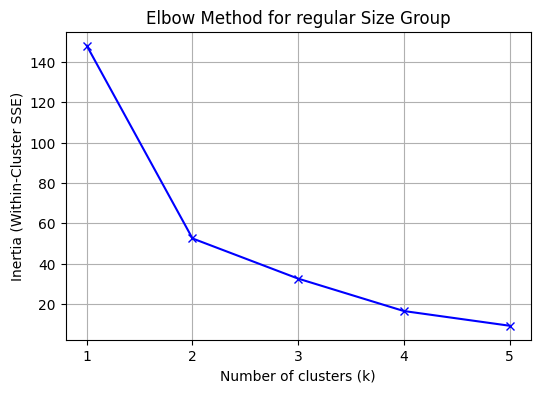

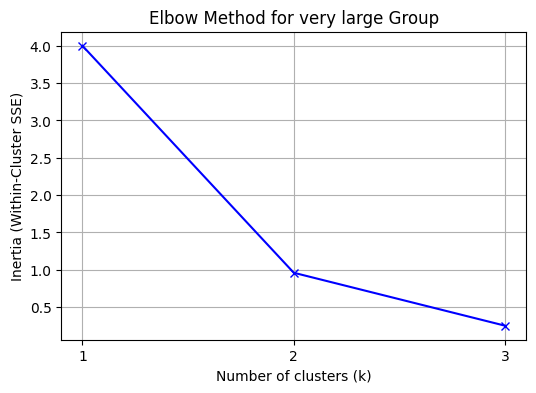

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Process for 'standard' size group
regular_group = df_cleaned[df_cleaned["volume_group"] == "regular"]
if regular_group.empty:
    print("No data for 'regular' size group. Skipping.")
else:
    # Extract price column for clustering
    X_price_regular = regular_group[["price_numeric"]].values

    # Skip clustering if there's only one row
    if len(regular_group) <= 1:
        print("Only one row in 'regular' size group. Skipping clustering.")
    else:
        # Scale prices for regular group
        scaler = StandardScaler()
        X_scaled_regular = scaler.fit_transform(X_price_regular)

        # Elbow method for the regular group
        distortions_regular = []
        K_range = range(1, 6)  # Try k = 1 to 5
        for k in K_range:
            kmeans_temp_regular = KMeans(n_clusters=k, random_state=0, n_init=10)
            kmeans_temp_regular.fit(X_scaled_regular)
            distortions_regular.append(kmeans_temp_regular.inertia_)

        # Plot Elbow Method for regular group
        plt.figure(figsize=(6, 4))
        plt.plot(K_range, distortions_regular, 'bx-')
        plt.title('Elbow Method for regular Size Group')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia (Within-Cluster SSE)')
        plt.xticks(K_range)  # Show integer ticks
        plt.grid(True)
        plt.show()

# Process for 'very large' group
large_group = df_cleaned[df_cleaned["volume_group"] == "very large"]
if large_group.empty:
    print("No data for 'very large' group. Skipping.")
else:
    # Extract price column for clustering
    X_price_large = large_group[["price_numeric"]].values

    # Skip clustering if there's only one row
    if len(large_group) <= 1:
        print("Only one row in 'very large' group. Skipping clustering.")
    else:
        # Scale prices for travel group
        scaler = StandardScaler()
        X_scaled_large = scaler.fit_transform(X_price_large)

        # Elbow method for the travel group
        distortions_large = []
        K_range = range(1, 4)  # Try k = 1 to 5
        for k in K_range:
            kmeans_temp_large = KMeans(n_clusters=k, random_state=0, n_init=10)
            kmeans_temp_large.fit(X_scaled_large)
            distortions_large.append(kmeans_temp_large.inertia_)

        # Plot Elbow Method for travel group
        plt.figure(figsize=(6, 4))
        plt.plot(K_range, distortions_large, 'bx-')
        plt.title('Elbow Method for very large Group')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia (Within-Cluster SSE)')
        plt.xticks(K_range)  # Show integer ticks
        plt.grid(True)
        plt.show()


In [100]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1) Make two volume bins
df_cleaned["volume_group"] = pd.cut(
    df_cleaned["volume"],
    bins=[0, 75, 250],
    labels=["regular", "very large"]
)

all_dfs = []

for group_name in ["regular", "very large"]:
    # 2) Subset data for that group and scale prices
    subset = df_cleaned[df_cleaned["volume_group"] == group_name].copy()
    X_price = subset[["price_numeric"]].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_price)

    # 3) Pick k=4 if high_volume, else k=6 if low_volume
    if group_name == "regular":
        k = 3
    else:
        k = 2

    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(X_scaled)

    # Store cluster labels in the subset
    subset["final_cluster"] = kmeans.labels_

    # Collect for concatenation later
    all_dfs.append(subset)

# 4) Combine back into one DataFrame
df_final = pd.concat(all_dfs, ignore_index=True)

# 5) Inspect cluster means, counts, etc.
summary = (
    df_final
    .groupby(["volume_group", "final_cluster"])["price_numeric"]
    .agg(["count", "mean", "min", "max"])
)
print(summary)


                            count        mean     min     max
volume_group final_cluster                                   
regular      0                 81   40.980000    9.59   62.10
             1                 43   84.044884   64.69  122.97
             2                 15  168.216667  129.36  344.39
very large   0                 10   60.781583   20.48  103.63
             1                  2  155.500000  124.00  187.00
             2                  0         NaN     NaN     NaN


<ipython-input-100-9be0da1f6b7b>:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["volume_group", "final_cluster"])["price_numeric"]


In [101]:

summary["price_range"] = summary["max"] - summary["min"]

# Sort the summary by price_range in descending order
sorted_summary = summary.sort_values(by="price_range", ascending=False)

# Display the sorted summary
print(sorted_summary)


                            count        mean     min     max  price_range
volume_group final_cluster                                                
regular      2                 15  168.216667  129.36  344.39       215.03
very large   0                 10   60.781583   20.48  103.63        83.15
             1                  2  155.500000  124.00  187.00        63.00
regular      1                 43   84.044884   64.69  122.97        58.28
             0                 81   40.980000    9.59   62.10        52.51
very large   2                  0         NaN     NaN     NaN          NaN


In [102]:
# Sort by mean price (ascending) within each volume group
sorted_summary = summary.sort_values(by=["volume_group", "mean"], ascending=[True, True])

# Display the sorted summary
print(sorted_summary)


                            count        mean     min     max  price_range
volume_group final_cluster                                                
regular      0                 81   40.980000    9.59   62.10        52.51
             1                 43   84.044884   64.69  122.97        58.28
             2                 15  168.216667  129.36  344.39       215.03
very large   0                 10   60.781583   20.48  103.63        83.15
             1                  2  155.500000  124.00  187.00        63.00
             2                  0         NaN     NaN     NaN          NaN


Cruelty free - american - korean - canadian - multipurpose

In [103]:

#df_high = df_final[df_final["volume_group"] == "high_volume"]

regular_highend = df_final[
    (df_final["volume_group"] == "regular") &
    (df_final["final_cluster"] == 2)
]
pd.set_option('display.max_colwidth', None)

price_std = regular_highend["price_numeric"].std()
print(price_std)
regular_highend


53.98109294223391


,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
5,برون امبولة كونترول هيالورونيك اكوا سولوشن من اتش واي - سيروم كوري معزز للوجه للاستخدام كمصل للعناية بالبشرة 1.18 اونصة سائلة، دهنية، للجنسين,141.44,4.3,34.810,regular,1.0,2.0,3.0,2.0,2
11,بلو نكتار سيروم جولد 24 قيراط للبشرة المتوهجة | مصل زيت كومكومادي الطبيعي للوجه غني بالذهب عيار | الوجه الايورفيدا لتفتيح البشرة وشدها عشب 30 مل، للجنسين,132.61,4.0,30.000,regular,1.0,2.0,3.0,2.0,2
12,بلوم سيروم ميلكي سبوت اند سكار فيد - مصل البقع الداكنة لاستعادة البشرة لتحسين الملمس والسطوع - غني بحمض الهيالورونيك وفيتامين C وE والنياسيناميد - تم اختباره من قبل اطباء الجلدية (1 اونصة)، كل الأنواع,344.39,4.2,29.500,regular,1.0,1.0,2.0,4.0,2
13,بليس برايت ايديا فيتامين سي ومصل ثلاثي الببتيد لحماية الكولاجين وتفتيح البشرة | يضيء ويقلل من البقع الداكنة ويشد بشكل واضح نظيف خالٍ البارابين الحيوانات نباتي 1 أونصة، للنساء، لنوع جافة، 1.0 اونصة,129.36,4.4,29.500,regular,1.0,2.0,3.0,2.0,2
18,جلام اب سيروم باكوشيول مرطب ثابت - بديل طبيعي للريتينول والخطوط الدقيقة الضبابية والتجاعيد والبقع الداكنة، يرطب بشرة الوجه، لم يتم اختباره على الحيوانات (1.01 اونصة سائلة)، للجنسين، كل الأنواع,139.08,4.3,29.795,regular,1.0,2.0,3.0,2.0,2
20,دكتور سيروم الوجه المنشط بفيتامين C 7.5% من لوسيل 37 مل / بالنياسيناميد يضيء البشرة ويجدد خلايا ويقلل البقع الداكنة ويوحد اللون ويرطب ويعزز الحصول على بشرة شابة ومشرقة,147.99,4.7,37.000,regular,1.0,2.0,3.0,2.0,2
21,دكتور سيروم للوجه بفيتامين B5 بنسبة 4% من لوسيل جابان 37 مل / نياسيناميد مضاد للأكسدة يقلل التجاعيد والبهتان ويخفف البقع ويرطب ويقلل الاحمرار ويحسن المرونة ويعزز بشرة صحية ومتوهجة,145.99,5.0,37.000,regular,1.0,2.0,3.0,2.0,2
22,دي ايليفنث سيروم كافيين للوجه من كوريا 37 مل مضاد للشيخوخة ومضاد للاكسدة يصلح ويجدد جمال الشباب يحسن لمعان البشرة يحبس الرطوبة يتلاشى الخطوط الدقيقة يخفف وينشط بشرتك للجنسين دهنية مختلطه حساس جاف عادي,154.99,5.0,37.000,regular,1.0,2.0,3.0,1.0,2
61,سيروم تفتيح البشرة بفيتامين C من ذا فيس شوب | يفتح لون البشرة الباهتة وغير المتجانسة مع محلول فيتا الحيوي| يلمع البشرة ويرطبها ويلطفها ويعزز حاجز البشرة | منخفض التهيج، 1.01 اونصة سائلة اوز، كيه-بيوتي,188.13,4.6,29.795,regular,1.0,1.0,3.0,1.0,2
80,سيروم فيتامين سي ليف اكتيف لتفتيح البشرة ومقاومة علامات التقدم في السن من فيتشي، مكون 15% النقي وهاليورونيك اسيد وفيتامين اي لبشرة مشدودة اكثر اشراقا ونضارة، للجنسين، 0.33 اونصة,185.00,4.3,9.735,regular,1.0,1.0,3.0,1.0,2


good quality, imported (swiss, american, german)
indian, some multipurpose
korean

In [ ]:
regular_mid = df_final[
    (df_final["volume_group"] == "regular") &
    (df_final["final_cluster"] == 1)
]
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)  # Show all rows
price_std = regular_mid["price_numeric"].std()
print(price_std)
regular_mid

22.442571111972487


,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
1,اسايا سيروم وجه ريتينول 0.2% | صديق للمبتدئين | مضاد للشيخوخة والتجاعيد | سيروم ليلي للبشرة المتوهجة | فيتامين C وحمض الهيالورونيك | يقلل الخطوط الدقيقة ويعزز الكولاجين | لجميع انواع البشرة | 30 مل,70.18,4.8,30.000,regular,0.0,2.0,2.0,0.0,1
5,برون امبولة كونترول هيالورونيك اكوا سولوشن من اتش واي - سيروم كوري معزز للوجه للاستخدام كمصل للعناية بالبشرة 1.18 اونصة سائلة، دهنية، للجنسين,141.44,4.3,34.810,regular,1.0,0.0,1.0,2.0,1
8,بلو نكتار زيت كومكومادي الايورفيدا للوجه مع الزعفران النقي وخشب الصندل مصل مضاد للشيخوخة مرطب طبيعي للنساء 26 عشب 30 مل جاف دهنية حساس,83.62,4.2,30.000,regular,0.0,2.0,2.0,0.0,1
9,بلو نكتار سيروم الوجه بفيتامين C من ايورفيدا لتصحيح البقع الداكنة والبشرة المتوهجة | مصل حمض الهيالورونيك الطبيعي 100% مع فيتامين ثابت 9 اعشاب 30 مل,72.00,4.2,30.000,regular,0.0,2.0,2.0,0.0,1
10,بلو نكتار سيروم الوجه بفيتامين سي من مانجيستا مضاد للتجاعيد وشد البشرة | تركيبة متقدمة مضادة للشيخوخة مع قوة فيتامين اند اي | للوجه للبشرة المتوهجة التوت المشرق 13 عشب 30 مل,74.76,4.2,30.000,regular,0.0,2.0,2.0,0.0,1
11,بلو نكتار سيروم جولد 24 قيراط للبشرة المتوهجة | مصل زيت كومكومادي الطبيعي للوجه غني بالذهب عيار | الوجه الايورفيدا لتفتيح البشرة وشدها عشب 30 مل، للجنسين,132.61,4.0,30.000,regular,1.0,0.0,1.0,2.0,1
13,بليس برايت ايديا فيتامين سي ومصل ثلاثي الببتيد لحماية الكولاجين وتفتيح البشرة | يضيء ويقلل من البقع الداكنة ويشد بشكل واضح نظيف خالٍ البارابين الحيوانات نباتي 1 أونصة، للنساء، لنوع جافة، 1.0 اونصة,129.36,4.4,29.500,regular,1.0,0.0,1.0,2.0,1
14,بوفيه وببتيدات النحاس 1 بالمئة للخطوط الدقيقة والتجاعيد والترطيب، من ذا اورديناري، لنوع البشرة عادية، للجنسين، 30.0 ملليلتر,69.00,4.5,30.000,regular,0.0,2.0,2.0,0.0,1
17,تشيك نوتركس كريم اوتشاين - مع 2% نياسيناميد كوري + جلوتاثيون + فيتامين سي | يساعد على تفتيح البشرة الباهتة ويزيل البقع الداكنة والعيوب وعلامات حب الشباب والتصبغ | مصل بشرة زجاجي، للجنسين، 30.0 ملليلتر,111.30,4.1,30.000,regular,1.0,2.0,2.0,2.0,1
19,جلام اب سيروم باكوشيول مرطب ثابت - بديل طبيعي للريتينول والخطوط الدقيقة الضبابية والتجاعيد والبقع الداكنة، يرطب بشرة الوجه، لم يتم اختباره على الحيوانات (1.01 اونصة سائلة)، للجنسين، كل الأنواع,139.08,4.3,29.795,regular,1.0,0.0,1.0,2.0,1


japanese, indian,

In [ ]:
regular_low = df_final[
    (df_final["volume_group"] == "regular") &
    (df_final["final_cluster"] == 0)
]
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
price_std = regular_low["price_numeric"].std()
print(price_std)
regular_low


13.884505814429607


,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
0,أكسيس واي سيروم لتصحيح البقع الداكنة، 50 مل,32.06,4.1,50.000,regular,0.0,1.0,0.0,3.0,0
2,الحد الأدنى ألفا أربوتين 2 للتصبغ والبقع الداكنة وتسمّر الشمس - مصل للوجه حمض الهيالورونيك لإزالة العيوب وعلامات حب الشباب وتفاوت لون البشرة 30 ملليلتر للجنسين,40.20,4.1,30.000,regular,0.0,1.0,0.0,3.0,0
3,الحد الادنى سيروم الوجه 10 نياسيناميد لعلاج علامات حب الشباب والعيوب وموازنة الزيوت - الزنك مصل تنقية مضاد لحب للبشرة الدهنية والمعرضة 30 ملليلتر للجنسين,38.00,4.2,30.000,regular,0.0,1.0,0.0,3.0,0
4,الحد الادنى سيروم وجه بحمض الترانيكساميك بنسبة 3% لعلاج الكلف والتصبغ والحمامي وندبات حب الشباب للوجه مع حمض الهيالورونيك لازالة وفرط التصبغ الالتهابي او الحمامي PIH & PIE 30 مل للجنسين,45.95,4.1,30.000,regular,0.0,1.0,0.0,3.0,0
6,بلام سيروم الوجه بفيتامين C بنسبة 15% مع اليوسفي وحمض الاسكوربيك النقي فيتامين للوجه الماندرين الياباني والكاكادو خالٍ من العطور 20 مل كل الأنواع للجنسين,55.00,4.1,20.000,regular,0.0,1.0,0.0,0.0,0
7,بلام سيروم وجه 10% نياسيناميد مع ماء الارز وفيتامين B3 الياباني المخمر لبشرة صافية وخالية من العيوب ومشرقة تناسب جميع انواع البشرة خالية العطور 15 مل متعدد الالوان للجنسين,53.00,4.0,15.000,regular,0.0,1.0,0.0,3.0,0
15,بيوسانس مصل سكوالين + ببتيد نحاسي سريع النمو ترطيب قوي للوجه يملئ ويثبت على الفور بببتيدات النحاس المعززة بالكولاجين 1.77 اونصة سائلة لكل انواع البشرة للجنسين 50.0 ملليلتر كل الأنواع,43.00,4.4,50.000,regular,0.0,1.0,0.0,3.0,0
16,بيونكس - سيروم للوجه بفيتامين سي بنسبة 15% من ذا نورديا | للبقع الداكنة والخطوط الدقيقة والتجاعيد | 30 مل كل الأنواع للأنثى,38.95,3.5,30.000,regular,0.0,1.0,0.0,3.0,0
18,جارنيير مصل الوجه سكين اكتيف فاست برايت اوفرنايت بوستر مع فيتامين سي النقي بنسبة 10% للبلادة والبقع الداكنة، 30 مل، للجنسين، لنوع البشرة كل الأنواعة,46.15,4.6,30.000,regular,0.0,1.0,0.0,3.0,0
20,حمض الهيالورونيك 1.5 مع سيروم وجه بالذهب عيار 24 قيراط من زين اند ميزا لترطيب البشرة لمعان ومزيج وبدون مواد كيميائية ضارة للبشرة العادية والجافة زد ام مايزا 30 مل زدد زاين & للنساء زاين & مايزا,55.99,3.7,30.000,regular,0.0,1.0,0.0,0.0,0


mostly the same imported brands but the actually imported

In [ ]:
large_highmid = df_final[
    (df_final["volume_group"] == "very large") &
    (df_final["final_cluster"] == 1)
]
price_std = large_highmid["price_numeric"].std()
print(price_std)
large_highmid

nan


,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
149,سيروم حمض الهيالورونيك دايف-ان منخفض الجزيئات، للوجه والبشرة الجافة وغير المرطبة والدهنية، خال من العطور والكحول والملونات، نباتي ونظيف ولم يختبر على الحيوانات، حجم مضاعف 3.38 اونصة سائلة من توريدين,187.0,4.5,99.71,very large,1.0,0.0,1.0,1.0,1


UAE, VERY CHEAP, other imported mid

In [105]:
large_midlow = df_final[
    (df_final["volume_group"] == "very large") &
    (df_final["final_cluster"] == 0)
]
price_std = large_midlow["price_numeric"].std()
print(price_std)
large_midlow

28.108485358402334


,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
139,أمبولة سيروم وجه بمستخلص سنتيلّا اسياتيكا 100% المدغشقري لتهدئة البشرة الحساسة وتلك المعرض لحب الشباب من سكِن 1004 سكين1004 للجنسين 100.0 ملليلتر,58.000000,4.6,100.00,very large,0.0,0.0,0.0,0.0,0
140,دكتور راشيل سيروم برايمر للوجه مضاد للشيخوخة من جولد 24 كيه راديانس | يتوهج ويرطب ويشد البشرة ويساعد على إزالة التجاعيد، حجم 3.38 اونصة، كل الأنواع، للجنسين,35.000000,3.9,99.71,very large,0.0,0.0,0.0,3.0,0
141,سيروم 1 من بودرة حمض الهيالورونيك النقي للوجه 10.000 جزء في المليون - مضاد للشيخوخة + الخطوط الدقيقة + ترطيب مكثف + مرطب + بشرة ممتلئة بشكل واضح + يمنع الام المثانة 4 اونصة سائلة,97.590000,4.6,118.00,very large,NaN,NaN,NaN,NaN,0
142,سيروم بخاخ ايطالي وايت ترافل فيرست نباتي مرطب لامع للوجه - دالبا دالباميست بيدمونت للجنسين جاف عادي حساس مزيج دهنية 3.38 أونصة 100.0 مل من,103.630000,4.4,100.00,very large,1.0,2.0,1.0,2.0,0
144,سيروم فيتامين C والريتينول وحمض الهيالورونيك للوجه من يوث، مجموعة العناية بالبشرة لمكافحة الشيخوخة والتفتيح والترطيب والتجاعيد، 3 قطع، للجنسين، 1.0 fluid_ounces، كل الأنواع، 3.0 أونصة سائلة,48.303333,4.4,88.50,very large,0.0,0.0,0.0,3.0,0
145,سيروم فيتامين سي الممتاز للوجه بنسبة 20% مع حمض الهيالورونيك والريتينول والاحماض الامينية يعزز الكولاجين للبشرة يرطب البشرة ويمتلئها مضاد للشيخوخة والتجاعيد من ال بوب كل الأنواع للجنسين 82.0 ملليلتر,39.200000,4.2,82.00,very large,0.0,0.0,0.0,3.0,0
147,فوفل سيروم حمض الهيالورونيك للوجه مجموعة بي جلو للمبتدئين 035 اونصة 4 قوارير للأنثى جاف دهنية مزيج حساس عادي 100 ملليلتر للنساء,50.752500,4.2,100.00,very large,0.0,0.0,0.0,3.0,0
148,مستحلب مرطب رايس سيراميد من ذا فيس شوب لطيف لتفتيح وحاجز واقي لوشن للوجه مغذي عميق للبشرة الناعمة والمرنة 5.0 اونصة سائلة لنوع حساسة للجنسين,64.260000,4.4,147.50,very large,NaN,NaN,NaN,NaN,0
149,مصل الرمان والكولاجين لشد البشرة 80 مل من ذا فيس شوب لكل انواع للجنسين 0.1763696 اونص كل الأنواع,90.600000,4.3,80.00,very large,0.0,2.0,1.0,0.0,0
150,مصل الوجه التمهيدي للوجه دكتور راشيل عيار 24 قيراط 100 مل لكل انواع البشرة للجنسين كل الأنواع,20.480000,3.9,100.00,very large,0.0,0.0,0.0,3.0,0


In [ ]:
famous korean, chinese?

In [106]:
large = df_final[
    (df_final["volume_group"] == "very large") &
    (df_final["final_cluster"] == 1)
]
price_std = large["price_numeric"].std()
print(price_std)
large

44.54772721475249


,title,price_numeric,rating_numeric,volume,volume_group,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
143,سيروم حمض الهيالورونيك دايف-ان منخفض الجزيئات، للوجه والبشرة الجافة وغير المرطبة والدهنية، خال من العطور والكحول والملونات، نباتي ونظيف ولم يختبر على الحيوانات، حجم مضاعف 3.38 اونصة سائلة من توريدين,187.0,4.5,99.71,very large,1.0,1.0,3.0,1.0,1
146,سيروم نياسيناميد بيور من اشلي شاين: لترطيب وتبييض الوجه والجسم لجميع انواع البشرة، 250 مل، كل الأنواع,124.0,5.0,250.00,very large,NaN,NaN,NaN,NaN,1


Recommended B2C Price: 35.607917 RAS

>

Recommended B2B Price: 17.8RAS, assuming a retailer's margin of 50%
